# Stackoverflow data

## Init

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import os
import re
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from nltk.corpus import stopwords
from utils import monitor, examine_df
from sklearn.datasets.lfw import Bunch
from raw_preprocessor import RawPreprocessor
from html_preprocessor import HTMLPreprocessor

In [4]:
%matplotlib inline
sns.set_style('darkgrid')

In [5]:
args = Bunch()

## Read

In [6]:
args.data_kaggle_name = 'pythonquestions'

In [7]:
!pip install kaggle
!kaggle datasets download -d stackoverflow/$args.data_kaggle_name

pythonquestions.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
_base_path = f'~/.kaggle/datasets/stackoverflow/{args.data_kaggle_name}'
questions_path = os.path.join(_base_path, 'Questions.csv')
tags_path = os.path.join(_base_path, 'Tags.csv')

In [9]:
%time qdf = pd.read_csv(questions_path, encoding='ISO-8859-1')
examine_df(qdf)

CPU times: user 10.3 s, sys: 692 ms, total: 11 s
Wall time: 11 s
shape=(607282, 6)


name                    Id  OwnerUserId          CreationDate    Score  \
pos                      0            1                     2        3   
head 0                 469          147  2008-08-02T15:11:16Z       21   
     1                 502          147  2008-08-02T17:01:58Z       27   
     2                 535          154  2008-08-02T18:43:54Z       40   
     3                 594          116  2008-08-03T01:15:08Z       25   
     4                 683          199  2008-08-03T13:19:16Z       28   
tail 607277       40143190       333403  2016-10-19T23:36:01Z        1   
     607278       40143228  6.66246e+06  2016-10-19T23:40:00Z        0   
     607279       40143267  4.06468e+06  2016-10-19T23:44:07Z        0   
     607280       40143338  7.04498e+06  2016-10-19T23:52:27Z        2   
     607281       40143365  4.13313e+06  2016-10-19T23:55:49Z        0   
meta type            int64      float64                object    int64   
     has_null        False         True                 False    False   
math count          607282       601070                607282   607282   
     unique            NaN          NaN                606068      NaN   
     top               NaN          NaN  2016-08-29T11:28:51Z      NaN   
     freq              NaN          NaN                     3      NaN   
     mean      2.37196e+07  2.51959e+06                   NaN  2.28314   
     std       1.12472e+07  1.91038e+06                   NaN  19.2856   
     min               469           25                   NaN      -44   
     25%       1.48552e+07       853934                   NaN        0   
     50%        2.5319e+07  2.10768e+06                   NaN        1   
     75%       3.35882e+07  3.99116e+06                   NaN        2   
     max       4.01434e+07  7.04499e+06                   NaN     5524   

name                                                       Title  \
pos                                                            4   
head 0         How can I find the full path to a font from it...   
     1                   Get a preview JPEG of a PDF on Windows?   
     2         Continuous Integration System for a Python Cod...   
     3            cx_Oracle: How do I iterate over a result set?   
     4         Using 'in' to match an attribute of Python obj...   
tail 607277    How to execute multiline python code from a ba...   
     607278    How to get google reCaptcha image source using...   
     607279        Updating an ManyToMany field with Django rest   
     607280                                  Most possible pairs   
     607281              Theano operations returning odd results   
meta type                                                 object   
     has_null                                              False   
math count                                                607282   
     unique                                               606928   
     top                 TypeError: 'str' object is not callable   
     freq                                                      8   
     mean                                                    NaN   
     std                                                     NaN   
     min                                                     NaN   
     25%                                                     NaN   
     50%                                                     NaN   
     75%                                                     NaN   
     max                                                     NaN   

name                                                        Body  
pos                                                            5  
head 0         <p>I am using the Photoshop's javascript API t...  
     1         <p>I have a cross-platform (Python) applicatio...  
     2         <p>I'm starting work on a hobby project with a...  
     3         <p>There are several ways to iterate over a re...  
     4         <p>I don't remember whether I w

In [10]:
qdf.drop(['OwnerUserId', 'CreationDate', 'Score'], axis=1, inplace=True)
qdf.rename({c: c.lower() for c in qdf.columns}, axis=1, inplace=True)
examine_df(qdf, exclude='tail, math')

shape=(607282, 3)


name              id                                              title  \
pos                0                                                  1   
head 0           469  How can I find the full path to a font from it...   
     1           502            Get a preview JPEG of a PDF on Windows?   
     2           535  Continuous Integration System for a Python Cod...   
     3           594     cx_Oracle: How do I iterate over a result set?   
     4           683  Using 'in' to match an attribute of Python obj...   
meta type      int64                                             object   
     has_null  False                                              False   

name                                                        body  
pos                                                            2  
head 0         <p>I am using the Photoshop's javascript API t...  
     1         <p>I have a cross-platform (Python) applicatio...  
     2         <p>I'm starting work on a hobby project with a...  
     3         <p>There are several ways to iterate over a re...  
     4         <p>I don't remember whether I was dreaming or ...  
meta type                                                 object  
     has_null                                              False

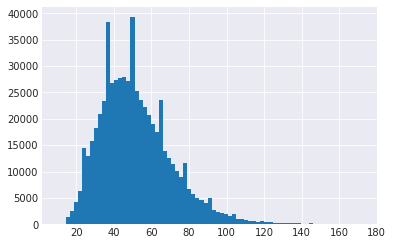

In [11]:
qdf.title.map(len).hist(bins=75);

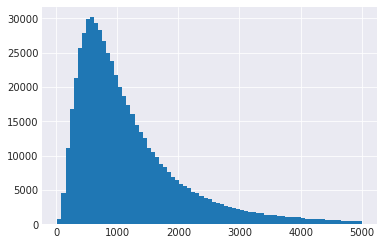

In [12]:
body_lens = qdf.body.map(len)
body_lens = body_lens[body_lens <= 5000]
body_lens.hist(bins=75);

## Text

In [13]:
args.log_step = 5000

In [14]:
sample = qdf.body.sample().iloc[0]
sample, HTMLPreprocessor().fit_transform([sample])[0]

('<p>I have to call a MS SQLServer stored procedure with a table variable parameter.</p>\n\n<pre><code>/* Declare a variable that references the type. */\nDECLARE @TableVariable AS [AList];\n\n/* Add data to the table variable. */\nINSERT INTO @TableVariable (val) VALUES (\'value-1\');\nINSERT INTO @TableVariable (val) VALUES (\'value-2\');\n\n\nEXEC  [dbo].[sp_MyProc]\n            @param = @TableVariable\n</code></pre>\n\n<p>Works well in the SQL Sv Management studio. I tried the following in python using PyOdbc:</p>\n\n<pre><code>cursor.execute("declare @TableVariable AS [AList]")\nfor a in mylist:\n    cursor.execute("INSERT INTO @TableVariable (val) VALUES (?)", a)\ncursor.execute("{call dbo.sp_MyProc(@TableVariable)}")\n</code></pre>\n\n<p>With the following error: error 42000 : the table variable must be declared. THe variable does not survive the different execute steps. \nI also tried:</p>\n\n<pre><code>sql = "DECLARE @TableVariable AS [AList]; "\nfor a in mylist:\n    sql = sq

In [15]:
preprocessor = HTMLPreprocessor(
    monitor=monitor('[1.6.1] Bodies filtering', log_step=args.log_step),
    do_tqdm=True
)
bodies = preprocessor.fit_transform(qdf.body)

100%|██████████| 607282/607282 [19:00<00:00, 532.58it/s]


In [16]:
%time texts = [f'{t}\n{b}' for t, b in zip(qdf.title, bodies)]
random.sample(texts, 3)

CPU times: user 332 ms, sys: 136 ms, total: 468 ms
Wall time: 467 ms


['Python test failed even after installing successfully\nI installed  Python on windows 7. The installation process finished fine. I was trying to test Python by typing  CODE , which did not work as shown in the figure. Did I miss any step?\n\n',
 'python networkx- save disconnected graphs from single figure into separate files\nI have following program that generates my graph and displays it on a single figure.\n\nEdges2 = [(1, 2), (1, 3), (1, 4), (4, 5), (6, 7), (6,8)]\nG = nx.DiGraph()\n\nThe function that generates the graph is as follows:\n CODE \nTo the above function I am passing the list of edges (Edges2). \nThe function generates two disconnected graphs on a single figure. However, I would like to save these two graphs separately.\nSo basically, is there a way of saving two disconnected graphs into two files? So, I can get graph1.png and graph2.png.\n',
 'Use dictwriter and write unstructured data into csv file using python\nOutput CSv fileI am currently trying to put the data

## Tags

In [17]:
tdf = pd.read_csv(tags_path, encoding='latin1')
examine_df(tdf, exclude='math')

shape=(1885078, 2)


name                 Id        Tag
pos                   0          1
head 0              469     python
     1              469        osx
     2              469      fonts
     3              469  photoshop
     4              502     python
tail 1885073   40143338     python
     1885074   40143365     python
     1885075   40143365      numpy
     1885076   40143365     theano
     1885077   40143365       nnet
meta type         int64     object
     has_null     False       True

In [18]:
tdf.rename({c: c.lower() for c in tdf.columns}, axis=1, inplace=True)
tdf = tdf.dropna()
tdf.reset_index(drop=True, inplace=True)
examine_df(tdf, exclude='tail, math')

shape=(1884635, 2)


name              id        tag
pos                0          1
head 0           469     python
     1           469        osx
     2           469      fonts
     3           469  photoshop
     4           502     python
meta type      int64     object
     has_null  False      False

In [19]:
print(f'total={len(tdf.tag.unique())}')
tdf.tag.value_counts()[:20]

total=16895


python               607283
django                62818
python-2.7            34616
pandas                26854
python-3.x            26814
numpy                 25848
list                  18951
matplotlib            16521
regex                 14047
dictionary            13413
tkinter               10766
string                10616
flask                 10488
google-app-engine     10286
csv                    9323
arrays                 9170
json                   8023
mysql                  7529
linux                  7121
html                   7118
Name: tag, dtype: int64

In [20]:
@monitor('[1.6.2] Join tags', log_step=args.log_step, log_total=len(tdf))
def join_tags(*, log):
    tags = [[] for _ in range(len(qdf))]
    id2i = dict(zip(qdf.id, qdf.index))
    for i, (_, (id_, tag)) in enumerate(tqdm(tdf.iterrows(), total=len(tdf))):
        if id_ in id2i:
            tags[id2i[id_]].append(tag)
        log.istep(i)
    return tags

In [21]:
tags = join_tags()
random.sample(tags, 3)

100%|██████████| 1884635/1884635 [03:21<00:00, 9370.92it/s]


[['python', 'dictionary', 'numbers'],
 ['python', 'rest', 'raspberry-pi', 'restful-url', 'webiopi'],
 ['python', 'pattern-matching', 'tuples']]

In [22]:
raw = [{'text': text, 'tags': i_tags} for text, i_tags in zip(texts, tags)]
random.sample(raw, 3)

[{'tags': ['python', 'google-app-engine', 'logging'],
  'text': 'GAE Logs API (Python) - Requests to Static Handler Do Not Show Up\nI have a python Google App Engine app and I wish to query my server logs to get some insight about requests handled by the static file handler. \nThat is, I have a static handler serving images from a folder called /static:\nfrom my app.yaml:\n CODE \nfor this purpose I am trying to get the logs using logservice class (Logs API), which is documented nicely here.\nlong story short, this is my bit of code that fetches the logs:\n CODE \nThe thing is, I am only getting logs for requests generated by the dynamic content handler. So while I am able to see logs for static requests in the GAE logs dashboard, and these requests are also accounted for when I download the logs using appcfg, they are not returned by the logservice.fetch metohd.\nIs there a way around this bug/weird design decision? I do not want to download the file using appcfg, I want to access the

In [23]:
preprocessor = RawPreprocessor(
    monitor=monitor('[1.6.3] Stackoverflow preprocessing', log_step=args.log_step),
    do_tqdm=True
)
df = preprocessor.fit_transform(raw)
examine_df(df, exclude='math')

100%|██████████| 607282/607282 [1:01:54<00:00, 163.48it/s]


shape=(517331, 2)


name                                                        text  \
pos                                                            0   
head 0         How can I find the full path to a font from it...   
     1         Get a preview JPEG of a PDF on Windows? DCNL I...   
     2         Continuous Integration System for a Python Cod...   
     3         cx_Oracle: How do I iterate over a result set?...   
     4         Using 'in' to match an attribute of Python obj...   
tail 517326    Trouble installing pillow for Windows 10 DCNL ...   
     517327    How to execute multiline python code from a ba...   
     517328    Updating an ManyToMany field with Django rest ...   
     517329    Most possible pairs DCNL Given a list of value...   
     517330    Theano operations returning odd results DCNL S...   
meta type                                                 object   
     has_null                                              False   

name                                 tags  
pos                                     1  
head 0         fonts osx photoshop python  
     1           image pdf python windows  
     2                             python  
     3         database oracle python sql  
     4            arrays iteration python  
tail 517326      django pillow pip python  
     517327         bash multiline python  
     517328                 django python  
     517329                        python  
     517330      nnet numpy python theano  
meta type                          object  
     has_null                       False

## Sanity check

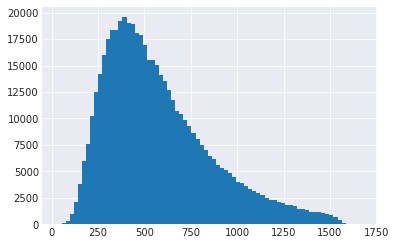

In [24]:
df.text.map(len).hist(bins=75);

In [25]:
df.text.sample(10).tolist()

["Improve speed when reading very large files in Python DCNL So I'm running multiple functions, each function takes a section out of the million line .txt file. Each function has a for loop that runs through every line in that section of million line file. DCNL It takes info from those lines to see if it matches info in 2 other files, one about 50,000-100,000 lines long, the other about 500-1000 lines long. I checked if the lines match by running for loops through the other 2 files. Once the info matches I write the output to a new file, all functions write to the same file. The program will produce about 2,500 lines a minute, but will slow down the longer it runs. Also, when I run one of the function, it does in about 500 a minute, but when I do it with 23 other processes it only makes 2500 a minute, why is that? DCNL Does anyone know why that would happen? Anyway, I could import something to make the program run/read through files faster, I am already using the CODE method. DCNL Can 

## Save

In [26]:
args.save_path = 'stackoverflow_data.hdf5'

In [27]:
%time df.to_hdf(args.save_path, 'df', mode='w', format='f', complevel=9)

CPU times: user 692 ms, sys: 716 ms, total: 1.41 s
Wall time: 1.76 s


In [28]:
!du -sh $args.save_path

300M	stackoverflow_data.hdf5


## End

In [29]:
args

{'data_kaggle_name': 'pythonquestions',
 'log_step': 5000,
 'save_path': 'stackoverflow_data.hdf5'}